# PyTorch Tutorial

Prerequisites:
1. Install Anaconda (Python3)
2. Install PyTorch
3. Run 'jupyter notebook'

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.autograd import Variable 
import numpy as np

## PyTorch Basics

Some importnat concepts in PyTorch:
1. Input -> the computation graph can compute a value given an input
2. Parameter -> this is the optimizable part of the network
3. Expresion -> output of a computation

In this excersize we will find $x|y(x) = 0$<br/>
We will start with $y(x) = 2x-4$

In [2]:
class LinearFunction(nn.Module):
    def __init__(self, a, b):
        super(LinearFunction, self).__init__()
        self.a = [a]
        self.b = [b]
        
        self.x = nn.Parameter(torch.FloatTensor([10*np.random.random()]))
        # we want to optimize x
        # hence x should be a parameter
        
    def forward(self):
        a = torch.autograd.Variable(torch.FloatTensor(self.a))
        b = torch.autograd.Variable(torch.FloatTensor(self.b))
 
        return  a*self.x + b
    
    def get_loss(self):
        return torch.abs(self())

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

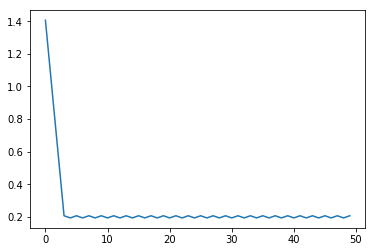

In [3]:
def minimize(func):
    optim = torch.optim.SGD(func.parameters(), lr = 0.1)
    loss_values = []
    for i in tqdm(range(50)):
        optim.zero_grad()
        loss = func.get_loss()
        loss_values.append(loss.data[0])
        loss.backward()
        optim.step()
         
    plt.plot(loss_values)
    plt.show() 
    
minimize(LinearFunction(2, -4))

### Exercise 1


1. Print the optimal x value found
2. How can we improve the x value?
3. Optimize a quadratic function. example: $x^2-4x+4$
4. Solve a set of equations with multiple variables. Example: 
$\begin{cases} 3x + 5y + z \\ 7x – 2y + 4z \\ -6x + 3y + 2z \end{cases}$

In [4]:
# ¯\_(ツ)_/¯

## "Deep" Neural Networks

Let's emulate a xor gate (it is well known that it is impossoble do it using a linear model)

HBox(children=(IntProgress(value=0, max=200000), HTML(value='')))

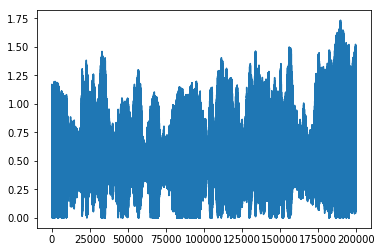

In [5]:
from itertools import product
from random import choice

def xor(a, b):
    if a == 0 and b == 0: return 0
    if a == 0 and b == 1: return 1
    if a == 1 and b == 0: return 1
    if a == 1 and b == 1: return 0

dataset = [(Variable(torch.Tensor([a, b])), Variable(torch.Tensor([xor(a, b)]))) for a, b in product(*[[0, 1]]*2)]

class XORNet(nn.Module):
    def __init__(self, hidden_dim):
        super(XORNet, self).__init__()
        self.linear1 = nn.Linear(2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x
    
def train(network):
    loss_values = []
    
    loss_func = nn.L1Loss()
    optim = torch.optim.SGD(network.parameters(), lr=0.001)
    for i in tqdm(range(50000*4)):
        x, y = choice(dataset)
        
        optim.zero_grad()
        pred = network(x)
        loss = loss_func(pred, y)
        loss_values.append(loss.data[0])
        loss.backward()
        optim.step()
         
    plt.plot(loss_values)
    plt.show() 
network = XORNet(20)
train(network)

### Exercise 2

Something is missing from the code, find out what it is ¯\\_(ツ)_/¯

## RNNs for Classification

In [6]:
from random import randint

def parChecker(symbolString):
    s = []
    balanced = True
    index = 0
    while index < len(symbolString) and balanced:
        symbol = symbolString[index]
        if symbol == "(": s.append(symbol)
        else:
            if not s: balanced = False
            else: s.pop()
        index = index + 1

    if balanced and not s: return Variable(torch.LongTensor([1]))
    else: return Variable(torch.LongTensor([0]))
    
x = [''.join([choice('()') for _ in range(randint(1, 5)*2)]) for i in range(10000)]
vocab = ['(', ')']
VOCAB_SIZE = len(vocab)
id2word = vocab
word2id = {word:i for i, word in enumerate(vocab)}

y = [parChecker(s) for s in x]

#vectorize dataset
x = [Variable(torch.LongTensor([[word2id[w] for w in string]])) for string in x]

dataset = list(zip(x, y))

In [7]:
class RNNClassifier(nn.Module):
    def __init__(self, embeddings_size, state_size):
        super(RNNClassifier, self).__init__()
        self.state_size = state_size

        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size)

        self.fwd_rnn = nn.LSTM(embeddings_size, state_size, 1)
        
        self.linear = nn.Linear(state_size, 2)

    def get_rnn_init_state(self):
        h0 = Variable(torch.zeros(1, 1, self.state_size))
        c0 = Variable(torch.zeros(1, 1, self.state_size))
        return h0, c0

    def forward(self, input_string):
        embedded = self.embeddings(input_string.transpose(1, 0))
        
        encoder_outputs, hn = self.fwd_rnn(embedded, self.get_rnn_init_state())
        logits = self.linear(encoder_outputs[-1])

        return logits #f.softmax(logits, dim=1) 

HBox(children=(IntProgress(value=0, max=200000), HTML(value='')))

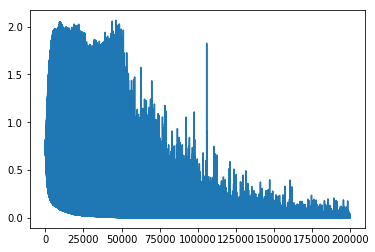

In [8]:
def train(network):
    loss_values = []
    
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(network.parameters(), lr=0.001)
    for i in tqdm(range(50000*4)):
        x, y = choice(dataset)
        
        optim.zero_grad()
        pred = network(x)
        loss = loss_func(pred, y)
        loss_values.append(loss.data[0])
        loss.backward()
        optim.step()
         
    plt.plot(loss_values)
    plt.show() 
network = RNNClassifier(4, 20)
train(network)

### Exercise 3

1. Make the LSTM a BiLSTM
2. This is very slow, can we make it faster (make the network batch friendly)?